In [1]:
import os


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random
from collections import OrderedDict

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import multiprocessing


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)



blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

blue = '#00AEEF'
red = '#F15A2A'

In [2]:
from src.model import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_cos_sim_torch

from network_parameters import network_parameters

from Figure_5_utils import blocked_interleaved
from src.utils.plotting import compare_distributions_12

In [3]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_sensory_sen_projection"] = True
network_parameters["mtl_sensory_sen_size"] = 30
network_parameters["max_post_mtl_sensory_sen"] = 1
network_parameters["max_pre_mtl_sensory_sen"] = np.inf

In [4]:
recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_semantic", "mtl_sensory", "ctx"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf

input_params = {}
input_params["num_days"] = 100
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {} 
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]


latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [5]:
X_sen = torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_semantic = torch.stack(network.activity_recordings["mtl_semantic"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sensory = torch.stack(network.activity_recordings["mtl_sensory"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_semantic, ordered_indices_mtl_semantic = get_ordered_indices(X_mtl_semantic, X_latent_AB, assembly_size=5)
selectivity_mtl_sensory, ordered_indices_mtl_sensory = get_ordered_indices(X_mtl_sensory, X_latent_AB, assembly_size=10)

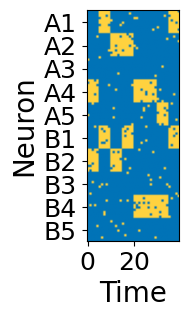

In [6]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["sen"], dim=0)[network.awake_indices][:input_params["day_length"], :100].reshape(-1, 100).T, cmap=blue_yellow)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)


plt.savefig('Figures_SVG/5a1.svg', dpi=300, transparent=True)

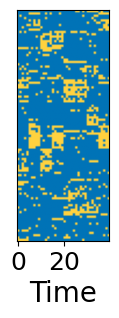

In [7]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl_sensory"], dim=0)[network.awake_indices][:input_params["day_length"], :100][:, ordered_indices_mtl_sensory[:100]].reshape(-1, 100).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)


plt.savefig('Figures_SVG/5a2.svg', dpi=300, transparent=True)

In [8]:
recording_parameters = {}
recording_parameters["regions"] = ["mtl_sensory", "mtl_semantic", "mtl", "ctx"]
recording_parameters["rate_activity"] = np.inf
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2


latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

In [9]:
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")


num_cpu = 100
trainings = ["interleaved", "blocked"]
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [10]:
experiment_params = [(network_parameters, recording_parameters, input_params, latent_specs, training, seed) for training in trainings for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(blocked_interleaved, experiment_params)
#save_results(results_list, filename='fig_5_blokced_interleaved.pickle')

starting simulation interleaved - 0
starting simulation interleaved - 1starting simulation interleaved - 2
starting simulation interleaved - 3

starting simulation interleaved - 4starting simulation interleaved - 5

starting simulation interleaved - 6starting simulation interleaved - 7
starting simulation interleaved - 8starting simulation interleaved - 9
starting simulation interleaved - 11starting simulation interleaved - 10



starting simulation interleaved - 12
starting simulation interleaved - 13
starting simulation interleaved - 14starting simulation interleaved - 15starting simulation interleaved - 16starting simulation interleaved - 17
starting simulation interleaved - 20


starting simulation interleaved - 21starting simulation interleaved - 22
starting simulation interleaved - 23starting simulation interleaved - 24
starting simulation interleaved - 25
starting simulation interleaved - 26starting simulation interleaved - 27starting simulation interleaved - 28
starting simulat

In [11]:
def save_results(results_list, filename):


    results = {}
    results["selectivity_mtl_semantic"] = []
    results["accuracy_mtl_semantic"] = []


    for selectivity_mtl_semantic, accuracy in results_list:


        results["selectivity_mtl_semantic"].append(selectivity_mtl_semantic)
        results["accuracy_mtl_semantic"].append(accuracy)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_5_blocked_interleaved.pickle')




In [12]:
with open('Data/{}'.format('fig_5_blocked_interleaved.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


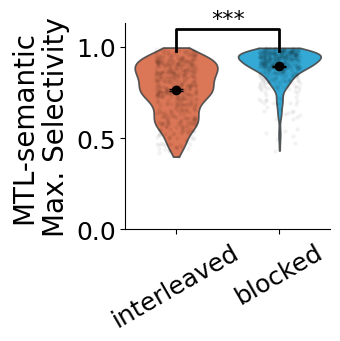

In [13]:

interleaved_max_sel = np.array(results["selectivity_mtl_semantic"][:num_seeds]).max(axis=1).flatten()
blocked_max_sel = np.array(results["selectivity_mtl_semantic"][num_seeds:]).max(axis=1).flatten()


dist1 = ('interleaved', interleaved_max_sel)
dist2 = ('blocked', blocked_max_sel)

palette = {
    "interleaved": red,   # light blue
    "blocked": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("MTL-semantic\nMax. Selectivity", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/5e.svg', dpi=300, transparent=True)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


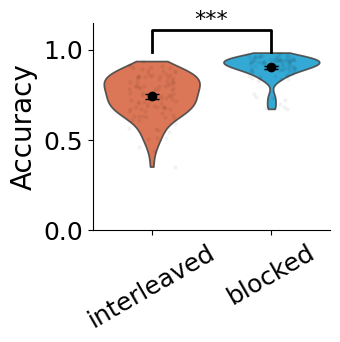

In [14]:


# Flatten arrays
interleaved_acc = np.array(results["accuracy_mtl_semantic"][:num_seeds]).flatten()
blocked_acc = np.array(results["accuracy_mtl_semantic"][num_seeds:]).flatten()


dist1 = ('interleaved', interleaved_acc)
dist2 = ('blocked', blocked_acc)

palette = {
    "interleaved": red,   # light blue
    "blocked": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/5f.svg', dpi=300, transparent=True)

In [15]:
median_interleaved_seed = np.argsort(np.array(results["accuracy_mtl_semantic"][:num_seeds]).mean(axis=1))[num_seeds//2]
median_blocked_seed = np.argsort(np.array(results["accuracy_mtl_semantic"][num_seeds:]).mean(axis=1))[num_seeds//2]

best_interleaved_seed = np.argsort(np.array(results["accuracy_mtl_semantic"][:num_seeds]).mean(axis=1))[-1]
best_blocked_seed = np.argsort(np.array(results["accuracy_mtl_semantic"][num_seeds:]).mean(axis=1))[-1]

In [16]:

network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = blocked_interleaved(network_parameters, recording_parameters, input_params, latent_specs, training='interleaved', seed=int(median_interleaved_seed), get_network=True)

network.selectivity_mtl_semantic = selectivity_mtl_semantic
network.selectivity_mtl_sensory = selectivity_mtl_sensory
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_5_interleaved_median.pt")



network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = blocked_interleaved(network_parameters, recording_parameters, input_params, latent_specs, training='interleaved', seed=int(best_interleaved_seed), get_network=True)

network.selectivity_mtl_semantic = selectivity_mtl_semantic
network.selectivity_mtl_sensory = selectivity_mtl_sensory
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_5_interleaved_best.pt")

starting simulation interleaved - 16
0
50
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
starting simulation interleaved - 19
0
50
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50


In [17]:
network_interleaved = torch.load("checkpoints/network_5_interleaved_best.pt", weights_only=False)

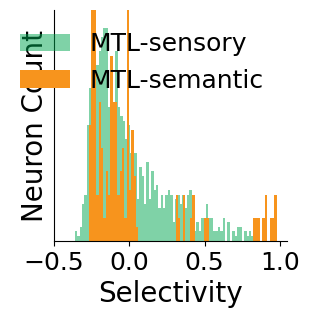

In [18]:
selectivity_mtl_sensory = network_interleaved.selectivity_mtl_sensory
selectivity_mtl_semantic = network_interleaved.selectivity_mtl_semantic

fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_sensory[selectivity_mtl_sensory != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_semantic[selectivity_mtl_semantic != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.ylim([0, 50])
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5c1.svg', dpi=300, transparent=True)

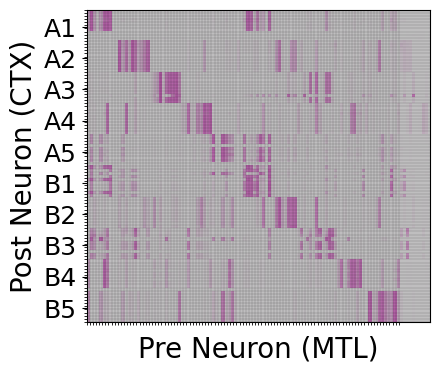

In [19]:
fig = plt.figure(figsize=(4.5, 4.5))

plt.imshow(network_interleaved.ctx_mtl[network_interleaved.ordered_indices_ctx][:100][:, network_interleaved.ordered_indices_mtl_sensory], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.savefig('Figures_SVG/5c2.svg', dpi=300, transparent=True)
plt.tight_layout()

In [20]:
network_interleaved = torch.load("checkpoints/network_5_interleaved_median.pt", weights_only=False)

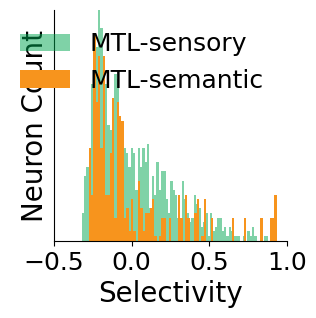

In [21]:
selectivity_mtl_sensory = network_interleaved.selectivity_mtl_sensory
selectivity_mtl_semantic = network_interleaved.selectivity_mtl_semantic

fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_sensory[selectivity_mtl_sensory != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_semantic[selectivity_mtl_semantic != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.ylim([0, 50])
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5c1_supp.svg', dpi=300, transparent=True)

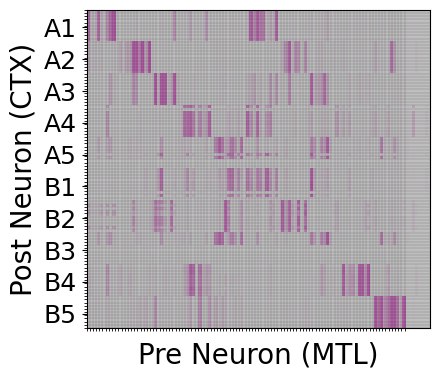

In [22]:
fig = plt.figure(figsize=(4.5, 4.5))

plt.imshow(network_interleaved.ctx_mtl[network_interleaved.ordered_indices_ctx][:100][:, network_interleaved.ordered_indices_mtl_sensory], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.savefig('Figures_SVG/5c2_supp.svg', dpi=300, transparent=True)
plt.tight_layout()

In [23]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = blocked_interleaved(network_parameters, recording_parameters, input_params, latent_specs, training='blocked', seed=int(median_blocked_seed), get_network=True)
network.selectivity_mtl_semantic = selectivity_mtl_semantic
network.selectivity_mtl_sensory = selectivity_mtl_sensory
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_5_blocked_median.pt")


network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_sensory, ordered_indices_mtl_semantic, selectivity_ctx, selectivity_mtl_sensory, selectivity_mtl_semantic, accuracy = blocked_interleaved(network_parameters, recording_parameters, input_params, latent_specs, training='blocked', seed=int(best_blocked_seed), get_network=True)
network.selectivity_mtl_semantic = selectivity_mtl_semantic
network.selectivity_mtl_sensory = selectivity_mtl_sensory
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_sensory = ordered_indices_mtl_sensory
network.ordered_indices_mtl_semantic = ordered_indices_mtl_semantic

torch.save(network, "checkpoints/network_5_blocked_best.pt")

starting simulation blocked - 8
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
starting simulation blocked - 4
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50


In [24]:
network_blocked = torch.load("checkpoints/network_5_blocked_best.pt", weights_only=False)

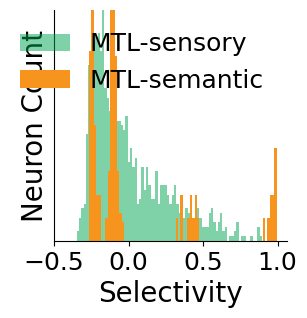

In [25]:
selectivity_mtl_sensory = network_blocked.selectivity_mtl_sensory
selectivity_mtl_semantic = network_blocked.selectivity_mtl_semantic

fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_sensory[selectivity_mtl_sensory != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_semantic[selectivity_mtl_semantic != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.ylim([0, 50])
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5d1.svg', dpi=300, transparent=True)

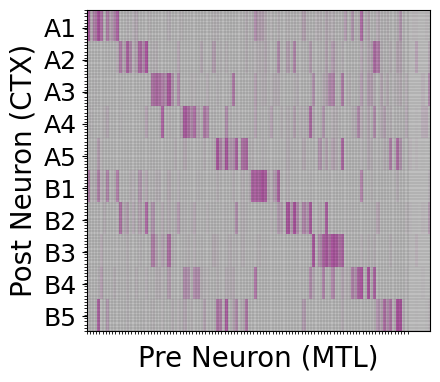

In [26]:
fig = plt.figure(figsize=(4.5, 4.5))

plt.imshow(network_blocked.ctx_mtl[network_blocked.ordered_indices_ctx][:100][:, network_blocked.ordered_indices_mtl_sensory], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.savefig('Figures_SVG/5d2.svg', dpi=300, transparent=True)
plt.tight_layout()

In [27]:
network_blocked = torch.load("checkpoints/network_5_blocked_median.pt", weights_only=False)

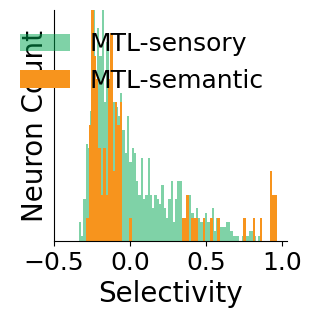

In [28]:
selectivity_mtl_sensory = network_blocked.selectivity_mtl_sensory
selectivity_mtl_semantic = network_blocked.selectivity_mtl_semantic

fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_sensory[selectivity_mtl_sensory != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_semantic[selectivity_mtl_semantic != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.ylim([0, 50])
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5d1_supp.svg', dpi=300, transparent=True)

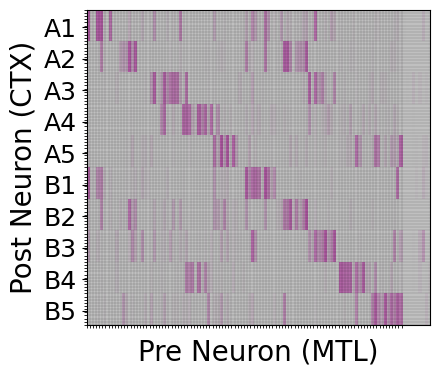

In [29]:
fig = plt.figure(figsize=(4.5, 4.5))

plt.imshow(network_blocked.ctx_mtl[network_blocked.ordered_indices_ctx][:100][:, network_blocked.ordered_indices_mtl_sensory], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL)", fontsize=20)
plt.savefig('Figures_SVG/5d2_supp.svg', dpi=300, transparent=True)
plt.tight_layout()

In [30]:
seed_everything(0)


recording_parameters = {}
recording_parameters["regions"] = ["mtl_sensory"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

In [31]:
input_params["num_days"] = 10
input_params["day_length"] = 200
input_params["mean_duration"] = 1

latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


prototype_A = torch.zeros(latent_specs["dims"][0], network.mtl_sensory_size)
replayed_A =  torch.zeros(latent_specs["dims"][0], input_params["num_days"]*network.sleep_duration_A, network.mtl_sensory_size)
prototype_B = torch.zeros(latent_specs["dims"][1], network.mtl_sensory_size)
replayed_B =  torch.zeros(latent_specs["dims"][0],  input_params["num_days"]*network.sleep_duration_A, network.mtl_sensory_size)

replayed_A[0] = torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.sleep_indices_A]
prototype_A[0] = network.activation(torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.awake_indices].mean(axis=0), "mtl_sensory", sleep=True)[0]
network.awake_indices = []
network.sleep_indices_A = []


0


In [32]:
for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
    replayed_A[k] = torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.sleep_indices_A]
    prototype_A[k] = network.activation(torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.awake_indices].mean(axis=0), "mtl_sensory", sleep=True)[0]
    network.awake_indices = []
    network.sleep_indices_A = []


for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
    replayed_B[k] = torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.sleep_indices_A]
    prototype_B[k] = network.activation(torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.awake_indices].mean(axis=0), "mtl_sensory", sleep=True)[0]
    network.awake_indices = []
    network.sleep_indices_A = []


0
0
0
0
0
0
0
0
0


In [33]:
def get_max_overlap(replayed, prototpyes):
    cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
    max_sim = torch.max(torch.stack(cos_sims, dim=0))
    return max_sim.item()

In [34]:

prototypes = torch.concat([prototype_A, prototype_B], axis=0)
max_overlaps_blocked = []
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[0]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[1]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[2]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[3]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_A[4]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[0]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[1]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[2]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[3]])
max_overlaps_blocked.extend([get_max_overlap(replayed, prototypes) for replayed in replayed_B[4]])

In [35]:
mtl_sensory_sen = network.mtl_sensory_sen.clone()

In [36]:
input_params["num_days"] = 100
input_params["day_length"] = 200
input_params["mean_duration"] = 1
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
network.mtl_sensory_sen = mtl_sensory_sen
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [37]:
replayed_interleaved = torch.stack(network.activity_recordings["mtl_sensory"], axis=0)[network.sleep_indices_A]
max_overlaps_interleaved = [get_max_overlap(replayed, prototypes) for replayed in replayed_interleaved]

In [38]:
interleaved_index = np.array(max_overlaps_interleaved).argsort()[500]
prototype = np.argmax([get_cos_sim_torch(replayed_interleaved[interleaved_index], prototype) for prototype in prototypes])
print(prototype)

0


In [39]:
[get_cos_sim_torch(replayed_interleaved[interleaved_index], prototype) for prototype in prototypes]

[tensor(0.6000),
 tensor(0.),
 tensor(0.),
 tensor(0.1000),
 tensor(0.1000),
 tensor(0.2000),
 tensor(0.2000),
 tensor(0.),
 tensor(0.),
 tensor(0.1000)]

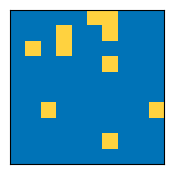

In [40]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(replayed_interleaved[interleaved_index].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g1.svg', dpi=300, transparent=True)

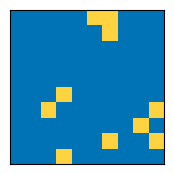

In [41]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(network.activation(prototype_A[0], "mtl_sensory", sleep=True)[0].reshape(-1, 10), vmin=0.4, cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g2.svg', dpi=300, transparent=True)

In [42]:
blocked_index = np.array(max_overlaps_blocked).argsort()[500]
print(blocked_index)

803


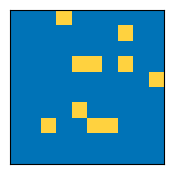

In [43]:
fig = plt.figure(figsize=(2, 2))

plt.imshow(replayed_B[4][3].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])

plt.savefig('Figures_SVG/5g3.svg', dpi=300, transparent=True)

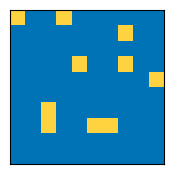

In [44]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(network.activation(prototype_B[4], "mtl_sensory", sleep=True)[0].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/5g4.svg', dpi=300, transparent=True)

In [45]:
[get_cos_sim_torch(replayed_B[4][3], prototype_B[4]) for prototype in prototypes]

[tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000),
 tensor(0.8000)]

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


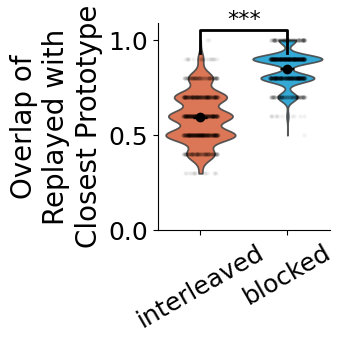

In [46]:
dist1 = ('interleaved', max_overlaps_interleaved)
dist2 = ('blocked', max_overlaps_blocked)

palette = {
    "interleaved": red,   # light blue
    "blocked": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Overlap of\nReplayed with\nClosest Prototype", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/5h.svg', dpi=300, transparent=True)
